<a href="https://colab.research.google.com/github/GunKK/capstone-project-brain-tumor-segmentation/blob/master/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from glob import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import cv2
IMG_HEIGHT=256
IMG_WIDTH=256

In [ ]:
def load_image(path):
    image=cv2.imread(path)
    image=cv2.resize(image,(IMG_WIDTH,IMG_HEIGHT))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image, axis=0)
    return image/255.0

def load_label(path):
    image=cv2.imread(path)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_AREA)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float32)
    return np.expand_dims(image/255.0,axis=-1)

In [ ]:
# load dataset yolo
data_path = '/content/drive/MyDrive/DATN/dataset_yolo'
images=[]
masks=[]

# load images
for i in sorted(os.listdir(data_path + "/images")):
  images.append(data_path + "/images/" + i)

for i in sorted(os.listdir(data_path + "/masks")):
  masks.append(data_path + "/masks/" + i)

for i in range(0,5):
  print(images[i])
  print(masks[i])

/content/drive/MyDrive/DATN/dataset_yolo/images/1.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/1.png
/content/drive/MyDrive/DATN/dataset_yolo/images/10.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/10.png
/content/drive/MyDrive/DATN/dataset_yolo/images/100.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/100.png
/content/drive/MyDrive/DATN/dataset_yolo/images/1000.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/1000.png
/content/drive/MyDrive/DATN/dataset_yolo/images/1001.png
/content/drive/MyDrive/DATN/dataset_yolo/masks/1001.png


In [ ]:
def xyxy(masks):
    x_min=[]
    y_min=[]
    x_max=[]
    y_max=[]
    zoom=5
    for path in masks:
        mask=load_label(path)
        occurrence = np.where(mask == 1)
        ymin=np.sort(occurrence[0])[0]
        ymax=np.sort(occurrence[0])[-1]
        xmin=np.sort(occurrence[1])[0]
        xmax=np.sort(occurrence[1])[-1]
        x_min.append(xmin-zoom)
        y_min.append(ymin-zoom)
        x_max.append(xmax+zoom)
        y_max.append(ymax+zoom)
    return (x_min,y_min,x_max,y_max)

In [ ]:
xy_xy=xyxy(masks)

In [ ]:
def show_sample(cnt):

    pic1=load_image(images[cnt])[0]
    pic2=load_label(masks[cnt])
    mask=load_image(images[cnt])[0]
    cv2.rectangle(mask, (xy_xy[0][cnt],xy_xy[1][cnt]),(xy_xy[2][cnt],xy_xy[3][cnt]), (0, 1, 0), 0)

    fig = plt.figure(figsize=(7, 6))

    ax = fig.add_subplot(1, 3, 1)
    ax.set_title("Brain Image")
    plt.imshow(pic1)

    ax = fig.add_subplot(1, 3, 2)
    ax.set_title("The Mask")
    plt.imshow(pic2)

    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(mask)

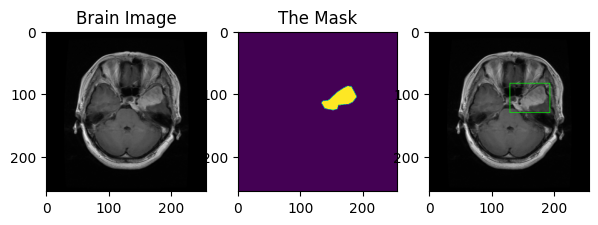

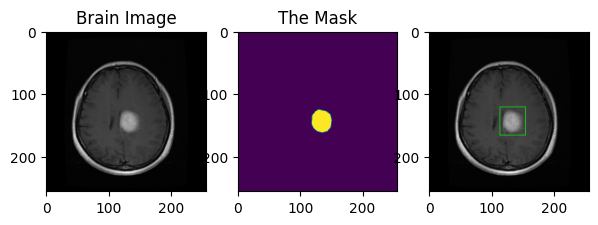

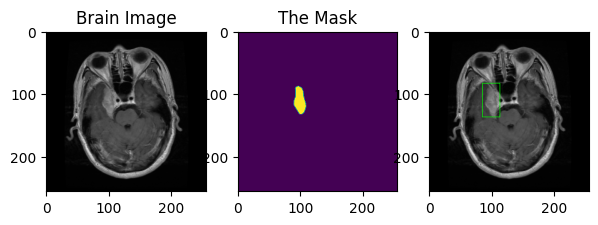

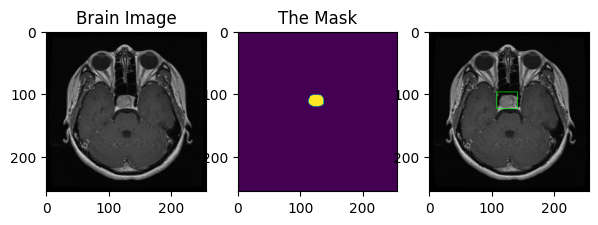

In [ ]:
for i in range(0,4):
    show_sample(i)

In [ ]:
load_label(masks[0]).shape

(256, 256, 1)

In [ ]:
binary_mask = load_label(masks[0])
binarya_mask = binary_mask.reshape(IMG_WIDTH, IMG_WIDTH)
binary_mask = binary_mask.astype(np.uint8)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
def mask_to_yolo_contours(mask, annotation_file):
    open(annotation_file, "w").close()
    binary_mask = load_label(mask)

    binarya_mask = binary_mask.reshape(IMG_WIDTH, IMG_WIDTH)
    binary_mask = binary_mask.astype(np.uint8)

    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        st = '0 '
        for i in cnt:
            st += str(i[0][0]/256) + ' ' + str(i[0][1]/256) + ' '
        with open(annotation_file, 'a') as ann_file:
            ann_file.write(st + '\n')

In [3]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-q_le5f7s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-q_le5f7s
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=e1cde36edeede7dde1097baeb525fd2457cf84ddf12ee1111e3f54440665239a
  Stored in directory: /tmp/pip-ephem-wheel-cache-jcaronde/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-05-26 22:13:53--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.74, 18.173.166.48, 18.173.166.31, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173

In [4]:
!pip install -U ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.4/778.4 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [5]:
!pip install -U ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [6]:
# import yolo
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()

# yolo_model = YOLO('yolov8n-seg')
yolo_model = YOLO("yolov8n.pt")

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.3/107.7 GB disk)


100%|██████████| 6.23M/6.23M [00:00<00:00, 76.9MB/s]


In [7]:
print(yolo_model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
# input_shape = (None, IMG_HEIGHT, IMG_WIDTH, 3)
print(yolo_model.info())

YOLOv8n summary: 225 layers, 3157200 parameters, 0 gradients, 8.9 GFLOPs
(225, 3157200, 0, 8.8575488)


In [ ]:
df = pd.DataFrame(images,columns=['images_path'])
df['mask_path'] = masks
df.head()

,images_path,mask_path
0,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...
1,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...
2,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...
3,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...
4,/content/drive/MyDrive/DATN/dataset_yolo/image...,/content/drive/MyDrive/DATN/dataset_yolo/masks...


In [ ]:
# split data train and test
from sklearn.model_selection import train_test_split

files = list(df.images_path.unique())
files_train,files_valid = train_test_split(files,test_size=0.2,random_state=42)
len(files_train),len(files_valid)

(2451, 613)

In [ ]:
IMAGES = "/content/drive/MyDrive/DATN/yolo_v1/images/"
LABELS = "/content/drive/MyDrive/DATN/yolo_v1/labels/"
os.makedirs(IMAGES+"train", exist_ok=True)
os.makedirs(LABELS+"train", exist_ok=True)
os.makedirs(IMAGES+"valid", exist_ok=True)
os.makedirs(LABELS+"valid", exist_ok=True)

In [ ]:
import shutil

train_filename = set(files_train)
valid_filename = set(files_valid)
# file ~ image_file
#
for i,file in enumerate(files):
    if file in train_filename:
        shutil.copy(file, IMAGES+"train")
        name = file.split("/")[7]
        anno_file = os.path.join(LABELS) + "train/"+name.replace('.png', '.txt')
        mask = os.path.join(data_path) + "/masks/" + name
        # params mask.png and ano_file.txt
        mask_to_yolo_contours(mask, anno_file)

    elif file in valid_filename:
        shutil.copy(file, IMAGES+"valid")
        name = file.split("/")[7]
        anno_file = os.path.join(LABELS) + "valid/"+name.replace('.png', '.txt')
        mask = os.path.join(data_path) + "/masks/" + name
        mask_to_yolo_contours(mask, anno_file)

In [ ]:
%%writefile  /content/drive/MyDrive/DATN/yolo_v1/dataset.yaml
# Path
train: /content/drive/MyDrive/DATN/yolo_v1/images/train
val: /content/drive/MyDrive/DATN/yolo_v1/images/valid

# Classes
nc: 1
names: ['Tumor']

Writing /content/drive/MyDrive/DATN/yolo_v1/dataset.yaml


In [ ]:
# train model
result = yolo_model.train(data="/content/drive/MyDrive/DATN/yolo_v1/dataset.yaml", epochs=10, batch=2,lr0=0.00001)

Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/DATN/yolo_v1/dataset.yaml, epochs=10, time=None, patience=100, batch=2, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True,

train: Scanning /content/drive/MyDrive/DATN/yolo_v1/labels/train.cache... 2451 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2451/2451 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/DATN/yolo_v1/labels/valid.cache... 613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 613/613 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=1e-05' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10     0.719G       1.55      1.551      1.519          1        640: 100%|██████████| 1226/1226 [02:24<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:13<00:00, 11.64it/s]

                   all        613        613      0.775      0.685      0.776      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10     0.568G      1.553      1.499      1.512          1        640: 100%|██████████| 1226/1226 [02:20<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:13<00:00, 11.71it/s]

                   all        613        613      0.793      0.661      0.767      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10     0.568G      1.562      1.449      1.539          1        640: 100%|██████████| 1226/1226 [02:36<00:00,  7.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:16<00:00,  9.39it/s]

                   all        613        613      0.804       0.67      0.774      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10     0.568G      1.547        1.4      1.527          1        640: 100%|██████████| 1226/1226 [02:24<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:11<00:00, 12.92it/s]

                   all        613        613      0.754      0.697      0.792      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10     0.568G      1.509      1.314      1.481          1        640: 100%|██████████| 1226/1226 [02:19<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:14<00:00, 10.64it/s]

                   all        613        613      0.802      0.641      0.784      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10     0.568G      1.442      1.195      1.436          1        640: 100%|██████████| 1226/1226 [02:15<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:13<00:00, 11.52it/s]


                   all        613        613      0.782      0.759      0.845      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10     0.568G      1.391      1.101      1.384          1        640: 100%|██████████| 1226/1226 [03:05<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:14<00:00, 10.60it/s]

                   all        613        613      0.847      0.778      0.866      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10     0.568G      1.369      1.029      1.383          1        640: 100%|██████████| 1226/1226 [02:33<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:17<00:00,  8.83it/s]

                   all        613        613      0.833      0.784      0.867      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10     0.568G       1.33     0.9956      1.345          1        640: 100%|██████████| 1226/1226 [02:59<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:14<00:00, 10.64it/s]

                   all        613        613      0.874      0.781      0.891      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10     0.568G      1.271     0.9192      1.309          1        640: 100%|██████████| 1226/1226 [02:31<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:12<00:00, 12.04it/s]

                   all        613        613      0.873      0.793      0.897      0.578



10 epochs completed in 0.468 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 154/154 [00:10<00:00, 15.23it/s]


                   all        613        613      0.871      0.793      0.896      0.578
Speed: 0.4ms preprocess, 6.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train2


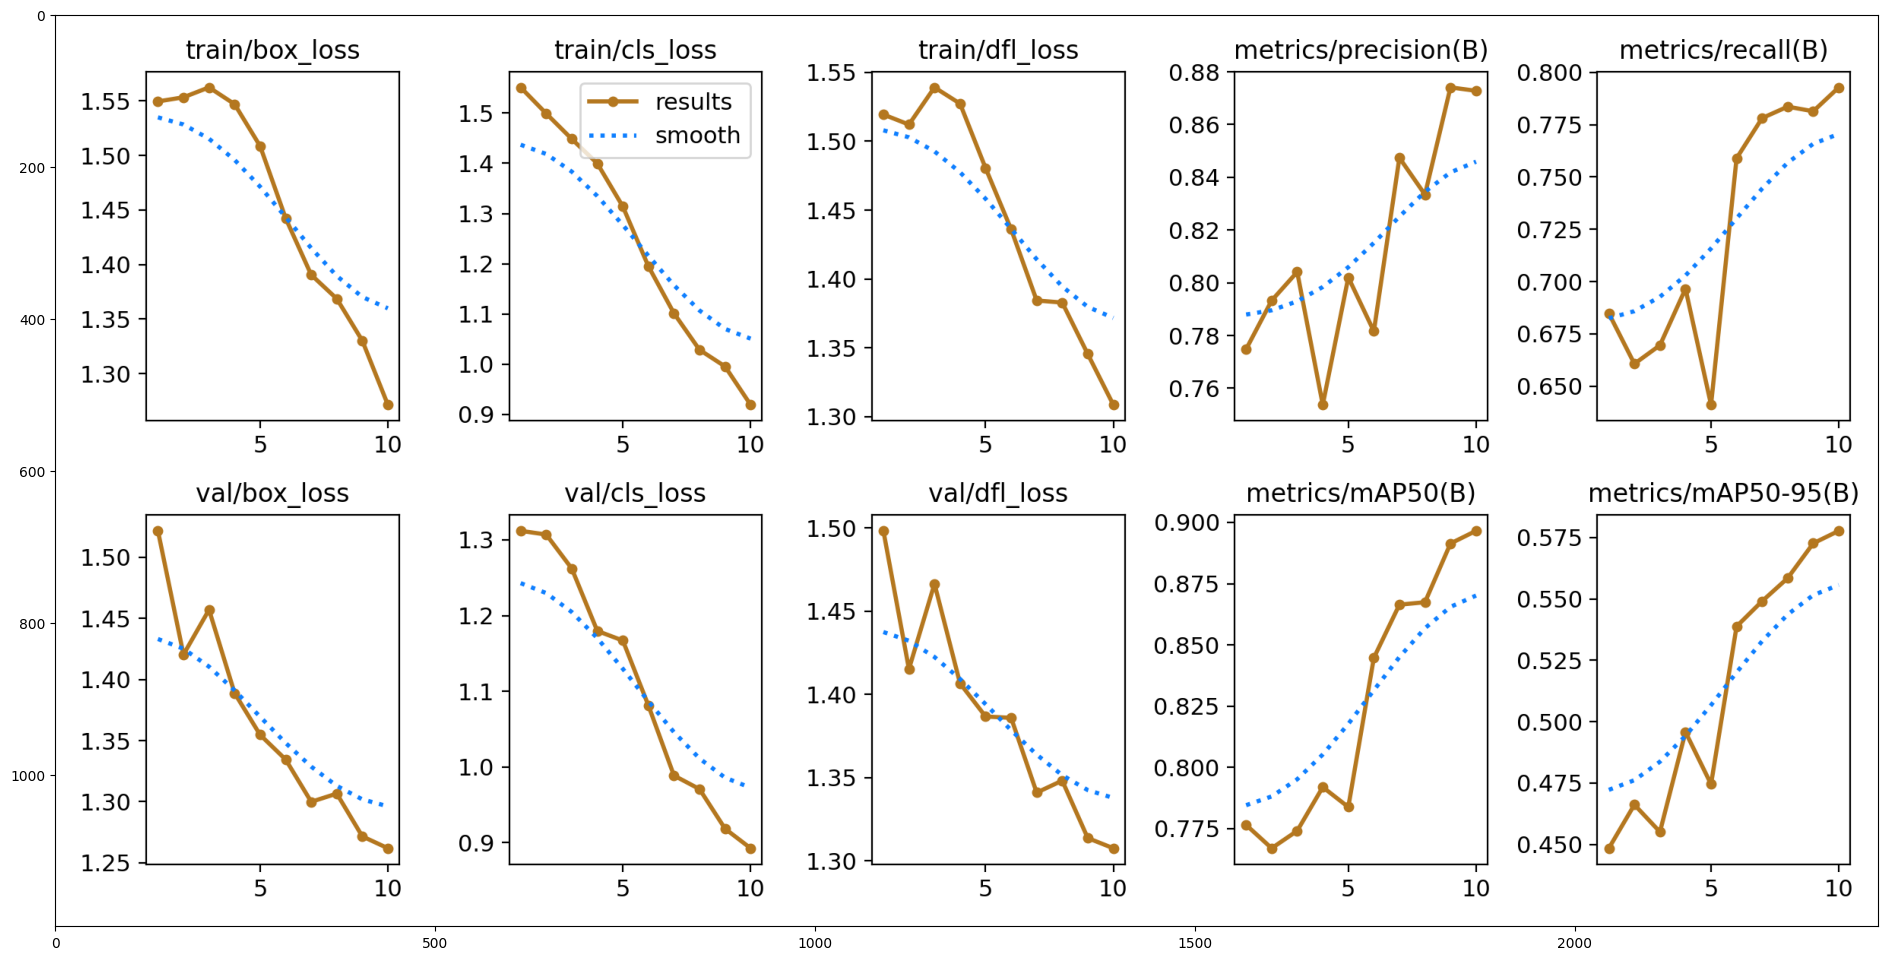

In [ ]:
from matplotlib import pyplot as plt
img = cv2.imread("/content/runs/detect/train2/results.png")
plt.figure(figsize=(80,80))
plt.subplot(1,3,1)
plt.imshow(np.squeeze(img))
# plt.title('Brain Image')
# plt.subplot(i,3,2)
# plt.imshow(np.squeeze(cv2.imread(df_tumor_test['masks'].iloc[index])))
# plt.title('Ground True')
# plt.subplot(i,3,3)
# plt.imshow(np.squeeze(pred > 0.5), cmap='gray')
# plt.title('Prediction')

In [ ]:
# Load a model
# import ultralytics
# from ultralytics import YOLO
# from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
# from IPython.display import display, Image
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# ultralytics.checks()
# model = YOLO("/content/runs/detect/train/weights/best.pt")

# # Inference using the model
# predict = model.predict("/content/drive/MyDrive/DATN/yolo_test/")

KeyboardInterrupt: 

In [10]:
# test model
import random
import numpy as np
import ultralytics
from ultralytics import YOLO
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from IPython.display import display, Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
ultralytics.checks()
# load model with weights
model = YOLO("/content/drive/MyDrive/DATN/yolo_v1/best.pt")





Ultralytics YOLOv8.2.22 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.4/107.7 GB disk)



image 1/1 /content/drive/MyDrive/DATN/yolo_v1/images/valid/2990.png: 640x640 1 Tumor, 495.7ms
Speed: 12.7ms preprocess, 495.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/DATN/yolo_v1/images/valid/1435.png: 640x640 2 Tumors, 226.0ms
Speed: 3.7ms preprocess, 226.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


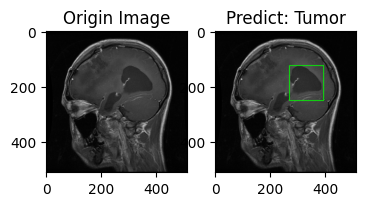

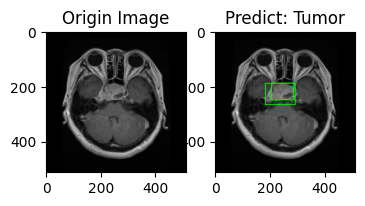

In [27]:
valid_path = '/content/drive/MyDrive/DATN/yolo_v1/images/valid'
for i in range(1,3):
    index = random.choice(os.listdir(valid_path))
    predict = model.predict(valid_path + "/" + index)
    # print(predict[0].names[0])
    predicted_boxes = predict[0].boxes.xyxy

    plt.figure(figsize=(4,4))
    plt.subplot(i,2,1)
    plt.imshow(cv2.imread(valid_path + "/" + index))
    plt.title('Origin Image')
    plt.subplot(i,2,2)
    for box in predicted_boxes:
        cv2.rectangle(predict[0].orig_img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    plt.imshow(predict[0].orig_img)
    plt.title('Predict: ' + predict[0].names[0])